# RP75 analysis and 2D graphics


The objective of this example is to present problem 75 of the BBRC. We also present graphic elements for the visualization of the limit state surface in 2 dimensions.

This problem has two dimension and a reference probability approximately equal to $10^{-2}$. Hence, the problem should be relatively easy to solve. The failure domain is made of two separate sub-domains, leading to two different design points. Hence, the FORM approximation cannot be accurate, because it systematically ignores one of them, no matter what point is found by the optimization algorithm.

In [1]:
import openturns as ot
import numpy as np
import otbenchmark as otb

In [2]:
problem = otb.ReliabilityProblem75()

In [3]:
print(problem)

name = RP75
event = class=ThresholdEventImplementation antecedent=class=CompositeRandomVector function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x1,x2,y0] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,x2] outputVariablesNames=[y0] formulas=[3 - x1 * x2] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,x2] outputVariablesNames=[y0] formulas=[3 - x1 * x2] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,x2] outputVariablesNames=[y0] formulas=[3 - x1 * x2] antecedent=class=UsualRandomVector distribution=class=ComposedDistribution name=ComposedDistribution dimension=2 copula=class=IndependentCopula name=IndependentCopula dimension=2 marginal[0]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] 

In [4]:
event = problem.getEvent()
g = event.getFunction()

In [5]:
problem.getProbability()

0.0107

In [6]:
# Create the Monte-Carlo algorithm
algoProb = ot.ProbabilitySimulationAlgorithm(event)
algoProb.setMaximumOuterSampling(1000)
algoProb.setMaximumCoefficientOfVariation(0.01)
algoProb.run()

In [7]:
# Get the results
resultAlgo = algoProb.getResult()
neval = g.getEvaluationCallsNumber()
print("Number of function calls = %d" % (neval))
pf = resultAlgo.getProbabilityEstimate()
print("Failure Probability = %.4f" % (pf))
level = 0.95
c95 = resultAlgo.getConfidenceLength(level)
pmin = pf - 0.5 * c95
pmax = pf + 0.5 * c95
print("%.1f %% confidence interval :[%.4f,%.4f] " % (level * 100, pmin, pmax))

Number of function calls = 1000
Failure Probability = 0.0080
95.0 % confidence interval :[0.0025,0.0135] 


## Compute the bounds of the domain

In [8]:
inputVector = event.getAntecedent()
distribution = inputVector.getDistribution()
X1 = distribution.getMarginal(0)
X2 = distribution.getMarginal(1)
alphaMin = 0.00001
alphaMax = 1 - alphaMin
lowerBound = ot.Point(
    [X1.computeQuantile(alphaMin)[0], X2.computeQuantile(alphaMin)[0]]
)
upperBound = ot.Point(
    [X1.computeQuantile(alphaMax)[0], X2.computeQuantile(alphaMax)[0]]
)

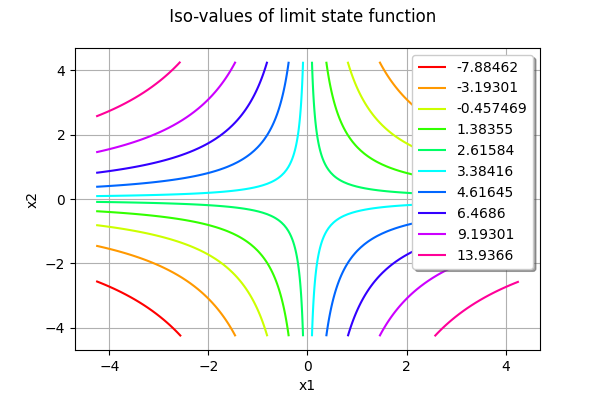

In [9]:
nbPoints = [100, 100]
figure = g.draw(lowerBound, upperBound, nbPoints)
figure.setTitle(" Iso-values of limit state function")
figure

## Print the iso-values of the distribution

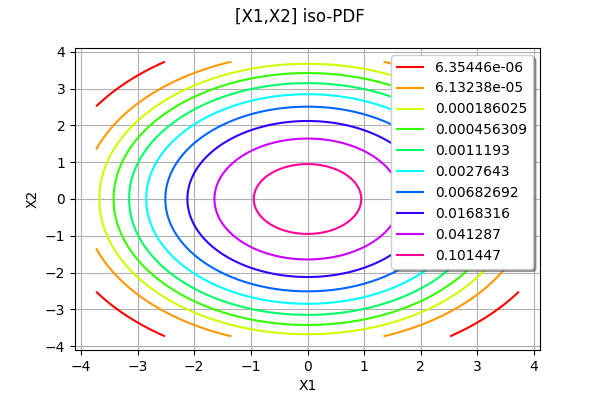

In [10]:
distribution.drawPDF()

In [11]:
sampleSize = 5000
drawEvent = otb.DrawEvent(event)

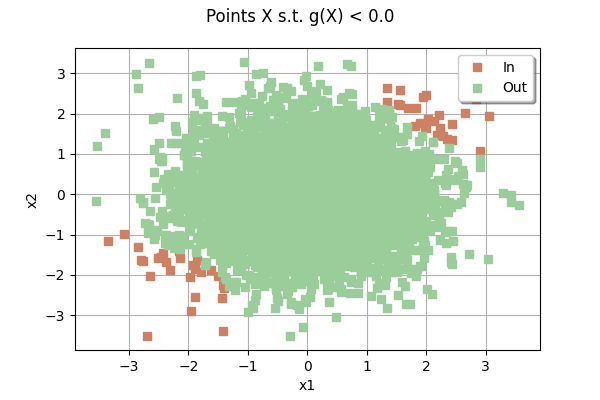

In [12]:
cloud = drawEvent.drawSampleCrossCut(sampleSize)
cloud

## Draw the limit state surface

In [13]:
bounds = ot.Interval(lowerBound, upperBound)
bounds

class=Interval name=Unnamed dimension=2 lower bound=class=Point name=Unnamed dimension=2 values=[-4.26489,-4.26489] upper bound=class=Point name=Unnamed dimension=2 values=[4.26489,4.26489] finite lower bound=[1,1] finite upper bound=[1,1]

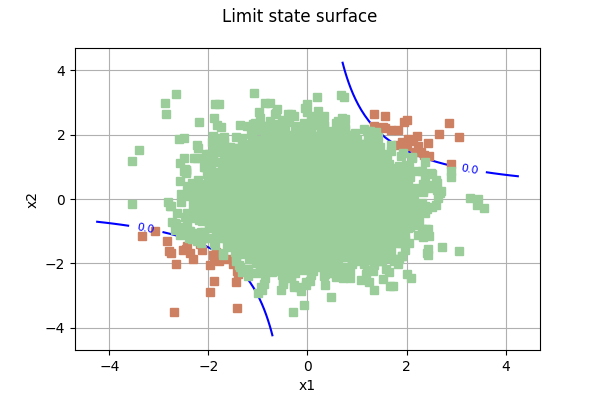

In [14]:
graph = drawEvent.drawLimitStateCrossCut(bounds)
graph.add(cloud)
graph

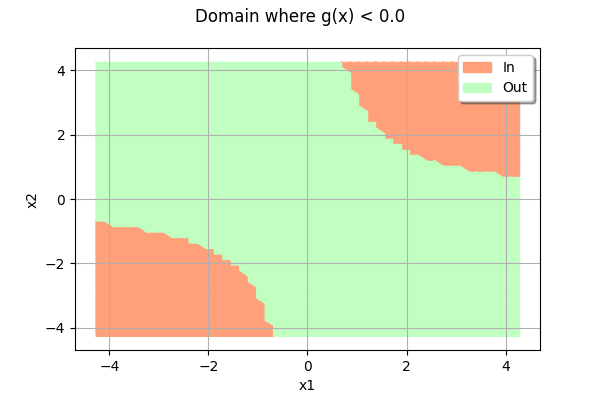

In [15]:
domain = drawEvent.fillEventCrossCut(bounds)
domain

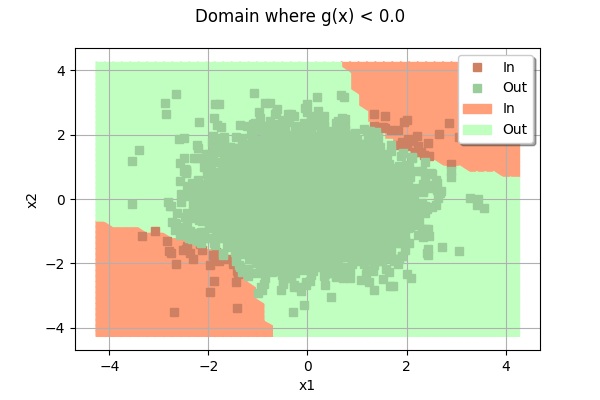

In [16]:
domain.add(cloud)
domain

## Test with FORM method

In [17]:
# We create a NearestPoint algorithm
nearestPointAlgorithm = ot.Cobyla()
# Resolution options:
eps = 1e-3
nearestPointAlgorithm.setMaximumCallsNumber(1000)
nearestPointAlgorithm.setMaximumAbsoluteError(eps)
nearestPointAlgorithm.setMaximumRelativeError(eps)
nearestPointAlgorithm.setMaximumResidualError(eps)
nearestPointAlgorithm.setMaximumConstraintError(eps)

In [18]:
initialNumberOfCall = g.getEvaluationCallsNumber()
mean = distribution.getMean()
algoFORM = ot.FORM(nearestPointAlgorithm, event, mean)
algoFORM.run()
resultFORM = algoFORM.getResult()
numberOfFunctionEvaluationsFORM = g.getEvaluationCallsNumber() - initialNumberOfCall
probabilityFORM = resultFORM.getEventProbability()
print("Number of calls to the limit state =", numberOfFunctionEvaluationsFORM)
print("Pf =", probabilityFORM)

Number of calls to the limit state = 154
Pf = 0.007161044716104123


In [19]:
# We create a NearestPoint algorithm
nearestPointAlgorithm = ot.AbdoRackwitz()
# Resolution options:
eps = 1e-3
nearestPointAlgorithm.setMaximumCallsNumber(100)
nearestPointAlgorithm.setMaximumAbsoluteError(eps)
nearestPointAlgorithm.setMaximumRelativeError(eps)
nearestPointAlgorithm.setMaximumResidualError(eps)
nearestPointAlgorithm.setMaximumConstraintError(eps)

If the mean point is used as a starting point with the `AbdoRackwitz` class, then the algorithm fails with:
```
RuntimeError: InternalException : Error in Abdo Rackwitz algorithm: the gradient of the level function is zero at point u=class=Point name=Unnamed dimension=2 values=[0,0]
```
In order to fix this, we just use a different starting point.

In [20]:
startingPoint = mean + [1.0e-3] * 2

In [21]:
initialNumberOfCall = g.getEvaluationCallsNumber()
mean = distribution.getMean()
algoFORM = ot.FORM(nearestPointAlgorithm, event, startingPoint)
algoFORM.run()
resultFORM = algoFORM.getResult()
numberOfFunctionEvaluationsFORM = g.getEvaluationCallsNumber() - initialNumberOfCall
probabilityFORM = resultFORM.getEventProbability()
print("Number of calls to the limit state =", numberOfFunctionEvaluationsFORM)
print("Pf =", probabilityFORM)

Number of calls to the limit state = 15
Pf = 0.007148267752544499


In [22]:
mean

class=Point name=Unnamed dimension=2 values=[0,0]

In [23]:
g.gradient(mean)

class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=2 columns=1 values=[-0,-0]